# Summary

fjeioafjwe

# Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.regression.dimred import SIR

import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [69]:
file_path = "datasets/cleaned_data.csv"
df = pd.read_csv(file_path)
df.head()

,RIDAGEYR,INDFMPIR,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,BMXHIP,...,DMDEDUC2_4.0,DMDEDUC2_5.0,DMDEDUC2_nan,DMDMARTL_1.0,DMDMARTL_2.0,DMDMARTL_3.0,DMDMARTL_4.0,DMDMARTL_5.0,DMDMARTL_6.0,DMDMARTL_nan
0,66.0,0.820000,79.5,158.3,31.7,37.0,36.0,32.0,101.8,110.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,18.0,2.831865,66.3,175.7,21.5,46.6,38.8,27.0,79.3,94.4,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,13.0,1.880000,45.4,158.4,18.1,38.1,33.8,21.5,64.1,83.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,66.0,1.630000,53.5,150.2,23.7,31.8,30.6,27.4,88.2,90.1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,75.0,0.410000,88.8,151.1,38.9,31.9,36.0,38.1,113.0,131.3,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Dimensionality Reduction

In [66]:
df.columns

Index(['RIDAGEYR', 'INDFMPIR', 'BMXWT', 'BMXHT', 'BMXBMI', 'BMXLEG', 'BMXARML',
       'BMXARMC', 'BMXWAIST', 'BMXHIP', 'LBXGH', 'RIAGENDR_bin',
       'DMQMILIZ_bin', 'DMDBORN4_bin', 'DMDCITZN_bin', 'RIDRETH1_1.0',
       'RIDRETH1_2.0', 'RIDRETH1_3.0', 'RIDRETH1_4.0', 'RIDRETH1_5.0',
       'RIDRETH1_nan', 'RIDRETH3_1.0', 'RIDRETH3_2.0', 'RIDRETH3_3.0',
       'RIDRETH3_4.0', 'RIDRETH3_6.0', 'RIDRETH3_7.0', 'RIDRETH3_nan',
       'DMDEDUC2_1.0', 'DMDEDUC2_2.0', 'DMDEDUC2_3.0', 'DMDEDUC2_4.0',
       'DMDEDUC2_5.0', 'DMDEDUC2_nan', 'DMDMARTL_1.0', 'DMDMARTL_2.0',
       'DMDMARTL_3.0', 'DMDMARTL_4.0', 'DMDMARTL_5.0', 'DMDMARTL_6.0',
       'DMDMARTL_nan', 'RIDAGEYR_x_BMXBMI', 'BMXWAIST_x_INDFMPIR'],
      dtype='object')

# Linear Modelling

## Data Preparation

In [70]:
import statsmodels.api as sm


# 1. Split features and target
train = df
train["RIDAGEYR_x_BMXBMI"] = df["RIDAGEYR"] * df["BMXBMI"]
train["BMXWAIST_x_INDFMPIR"] = df["BMXWAIST"] * df["INDFMPIR"]

X = train.drop(columns=["LBXGH"])
X = sm.add_constant(X)  
y = train["LBXGH"]

train 

,RIDAGEYR,INDFMPIR,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,BMXHIP,...,DMDEDUC2_nan,DMDMARTL_1.0,DMDMARTL_2.0,DMDMARTL_3.0,DMDMARTL_4.0,DMDMARTL_5.0,DMDMARTL_6.0,DMDMARTL_nan,RIDAGEYR_x_BMXBMI,BMXWAIST_x_INDFMPIR
0,66.0,0.820000,79.5,158.3,31.7,37.0,36.0,32.0,101.8,110.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2092.2,83.476000
1,18.0,2.831865,66.3,175.7,21.5,46.6,38.8,27.0,79.3,94.4,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,387.0,224.566919
2,13.0,1.880000,45.4,158.4,18.1,38.1,33.8,21.5,64.1,83.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,235.3,120.508000
3,66.0,1.630000,53.5,150.2,23.7,31.8,30.6,27.4,88.2,90.1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1564.2,143.766000
4,75.0,0.410000,88.8,151.1,38.9,31.9,36.0,38.1,113.0,131.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2917.5,46.330000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,70.0,0.950000,49.0,156.5,20.0,34.4,32.6,25.1,82.2,87.3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1400.0,78.090000
6041,42.0,1.391422,97.4,164.9,35.8,38.2,36.6,40.6,114.8,112.8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1503.6,159.735220
6042,41.0,1.180000,69.1,162.6,26.1,39.2,35.2,26.8,86.4,102.7,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1070.1,101.952000
6043,14.0,2.240000,111.9,156.6,45.6,39.2,35.0,44.5,113.5,128.3,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,638.4,254.240000


                            OLS Regression Results                            
Dep. Variable:                  LBXGH   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     51.43
Date:                Tue, 08 Jul 2025   Prob (F-statistic):          9.58e-279
Time:                        15:58:15   Log-Likelihood:                -8090.6
No. Observations:                6045   AIC:                         1.625e+04
Df Residuals:                    6013   BIC:                         1.646e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
RIDAGEYR               -0.0007    

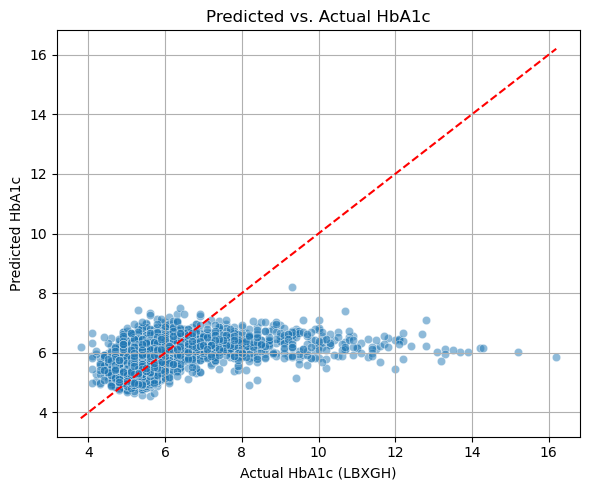

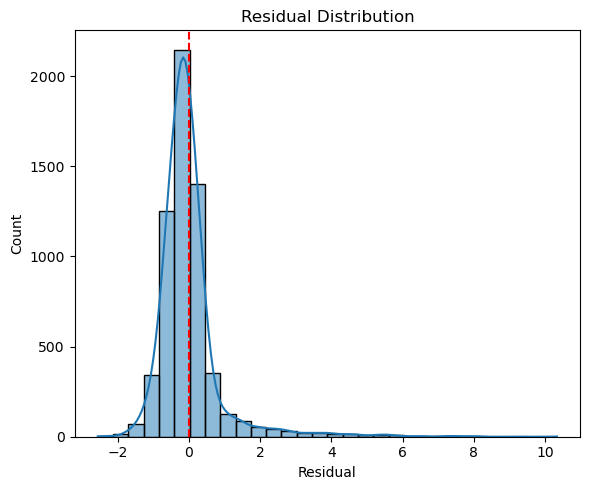

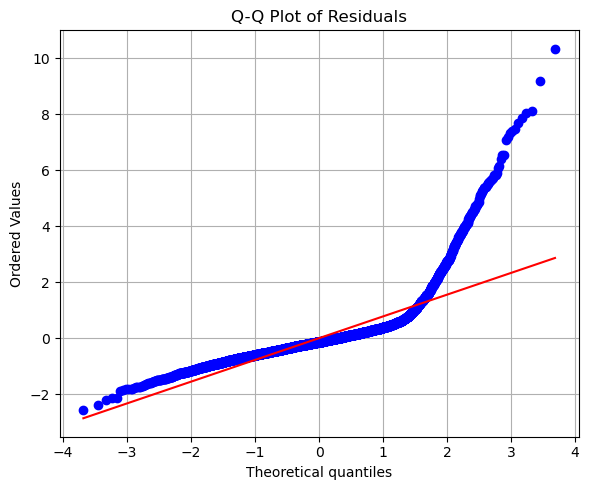

In [ ]:
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.api as sm


# 2. Fit linear regression
reg = sm.OLS(y, X).fit()

# 3. Get predictions
y_pred = reg.predict(X)

print(reg.summary())

# 5. Plot: Predicted vs Actual
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y, y=y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
plt.xlabel("Actual HbA1c (LBXGH)")
plt.ylabel("Predicted HbA1c")
plt.title("Predicted vs. Actual HbA1c")
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Plot: Residuals
residuals = y - y_pred
plt.figure(figsize=(6, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Residual")
plt.title("Residual Distribution")
plt.tight_layout()
plt.show()

# Q-Q plot
plt.figure(figsize=(6, 5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()


# Generative Additive Model

# WIP Model

# Model Evaluations